# Chapter 8: Deep Reinforcement Learning

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/adiel2012/reinforcement-learning/blob/main/notebooks/chapter08_deep_reinforcement_learning.ipynb)

This notebook implements deep reinforcement learning algorithms including DQN, Double DQN, and Dueling DQN with neural network function approximation.

## References
- **Mnih et al. (2015)**: Human-level control through deep reinforcement learning [5]
- **Van Hasselt et al. (2016)**: Deep reinforcement learning with double Q-learning [6]
- **Wang et al. (2016)**: Dueling network architectures for deep reinforcement learning [7]
- **Sutton & Barto (2018)**: Comprehensive treatment of function approximation [1]

## Cross-References
- **Prerequisites**: Chapter 7 (Function Approximation), Chapter 6 (Q-Learning Extensions)
- **Next**: Chapter 9 (Policy Gradients)
- **Related**: Chapter 11 (Advanced Policy Optimization), Chapter 12 (Model-Based Methods)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque, namedtuple
import random
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Try to import PyTorch, fallback to simple implementation if not available
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    import torch.nn.functional as F
    TORCH_AVAILABLE = True
    print("PyTorch available - using full deep learning implementation")
except ImportError:
    TORCH_AVAILABLE = False
    print("PyTorch not available - using simplified neural network implementation")

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
np.random.seed(42)
random.seed(42)

if TORCH_AVAILABLE:
    torch.manual_seed(42)

PyTorch available - using full deep learning implementation


## 8.1 CartPole Environment

We'll use CartPole as our test environment for deep RL algorithms.

In [2]:
class CartPoleEnv:
    """Simple CartPole environment implementation"""

    def __init__(self):
        # Environment parameters
        self.gravity = 9.8
        self.masscart = 1.0
        self.masspole = 0.1
        self.total_mass = self.masspole + self.masscart
        self.length = 0.5  # Half pole length
        self.polemass_length = self.masspole * self.length
        self.force_mag = 10.0
        self.tau = 0.02  # Time step

        # Thresholds
        self.theta_threshold_radians = 12 * 2 * np.pi / 360
        self.x_threshold = 2.4

        # State: [x, x_dot, theta, theta_dot]
        self.state = None
        self.steps = 0

    def reset(self):
        self.state = np.random.uniform(-0.05, 0.05, 4)
        self.steps = 0
        return self.state.copy()

    def step(self, action):
        x, x_dot, theta, theta_dot = self.state
        force = self.force_mag if action == 1 else -self.force_mag

        costheta = np.cos(theta)
        sintheta = np.sin(theta)

        temp = (force + self.polemass_length * theta_dot**2 * sintheta) / self.total_mass
        thetaacc = (self.gravity * sintheta - costheta * temp) / (
            self.length * (4.0/3.0 - self.masspole * costheta**2 / self.total_mass)
        )
        xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass

        x = x + self.tau * x_dot
        x_dot = x_dot + self.tau * xacc
        theta = theta + self.tau * theta_dot
        theta_dot = theta_dot + self.tau * thetaacc

        self.state = np.array([x, x_dot, theta, theta_dot])
        self.steps += 1

        done = bool(
            x < -self.x_threshold or x > self.x_threshold or
            theta < -self.theta_threshold_radians or theta > self.theta_threshold_radians or
            self.steps >= 500
        )

        reward = 1.0 if not done else 0.0

        return self.state.copy(), reward, done

    def get_state_dim(self):
        return 4

    def get_action_dim(self):
        return 2

# Test environment
env = CartPoleEnv()
state = env.reset()
print(f"Initial state: {state}")
print(f"State dimension: {env.get_state_dim()}")
print(f"Action dimension: {env.get_action_dim()}")

# Test a few steps
for i in range(5):
    action = np.random.randint(2)
    state, reward, done = env.step(action)
    print(f"Step {i+1}: action={action}, reward={reward}, done={done}")
    if done:
        break

Initial state: [-0.01254599  0.04507143  0.02319939  0.00986585]
State dimension: 4
Action dimension: 2
Step 1: action=0, reward=1.0, done=False
Step 2: action=1, reward=1.0, done=False
Step 3: action=0, reward=1.0, done=False
Step 4: action=0, reward=1.0, done=False
Step 5: action=0, reward=1.0, done=False


## 8.2 Neural Network Implementation

We'll implement neural networks for Q-function approximation.

In [3]:
if TORCH_AVAILABLE:
    # PyTorch implementation
    class DQN(nn.Module):
        def __init__(self, state_dim, action_dim, hidden_dims=[128, 128]):
            super(DQN, self).__init__()

            layers = []
            prev_dim = state_dim

            for hidden_dim in hidden_dims:
                layers.append(nn.Linear(prev_dim, hidden_dim))
                layers.append(nn.ReLU())
                prev_dim = hidden_dim

            layers.append(nn.Linear(prev_dim, action_dim))

            self.network = nn.Sequential(*layers)

        def forward(self, x):
            return self.network(x)

    class DuelingDQN(nn.Module):
        def __init__(self, state_dim, action_dim, hidden_dims=[128, 128]):
            super(DuelingDQN, self).__init__()

            # Shared feature layers
            self.feature_layers = nn.Sequential(
                nn.Linear(state_dim, hidden_dims[0]),
                nn.ReLU(),
                nn.Linear(hidden_dims[0], hidden_dims[1]),
                nn.ReLU()
            )

            # Value stream
            self.value_stream = nn.Sequential(
                nn.Linear(hidden_dims[1], hidden_dims[1] // 2),
                nn.ReLU(),
                nn.Linear(hidden_dims[1] // 2, 1)
            )

            # Advantage stream
            self.advantage_stream = nn.Sequential(
                nn.Linear(hidden_dims[1], hidden_dims[1] // 2),
                nn.ReLU(),
                nn.Linear(hidden_dims[1] // 2, action_dim)
            )

        def forward(self, x):
            features = self.feature_layers(x)
            values = self.value_stream(features)
            advantages = self.advantage_stream(features)

            # Combine value and advantage
            q_values = values + advantages - advantages.mean(dim=1, keepdim=True)
            return q_values

else:
    # Simple numpy implementation
    def relu(x):
        return np.maximum(0, x)

    def relu_derivative(x):
        return (x > 0).astype(float)

    class SimpleNN:
        def __init__(self, state_dim, action_dim, hidden_dims=[64, 64], lr=0.001):
            self.layers = []
            dims = [state_dim] + hidden_dims + [action_dim]

            # Initialize weights
            for i in range(len(dims) - 1):
                weight = np.random.randn(dims[i], dims[i+1]) * np.sqrt(2.0 / dims[i])
                bias = np.zeros(dims[i+1])
                self.layers.append({'weight': weight, 'bias': bias})

            self.lr = lr
            self.activations = []
            self.z_values = []

        def forward(self, x):
            self.activations = [x]
            self.z_values = []

            for i, layer in enumerate(self.layers):
                z = np.dot(self.activations[-1], layer['weight']) + layer['bias']
                self.z_values.append(z)

                if i < len(self.layers) - 1:  # Hidden layers
                    a = relu(z)
                else:  # Output layer
                    a = z

                self.activations.append(a)

            return self.activations[-1]

        def backward(self, target, prediction):
            # Simple MSE loss backpropagation
            batch_size = target.shape[0] if len(target.shape) > 1 else 1

            # Output layer error
            delta = (prediction - target) / batch_size

            # Backpropagate
            for i in range(len(self.layers) - 1, -1, -1):
                # Update weights
                self.layers[i]['weight'] -= self.lr * np.dot(self.activations[i].T, delta)
                self.layers[i]['bias'] -= self.lr * np.sum(delta, axis=0)

                if i > 0:  # Not input layer
                    # Compute delta for previous layer
                    delta = np.dot(delta, self.layers[i]['weight'].T)
                    delta *= relu_derivative(self.z_values[i-1])

        def copy_weights_from(self, other_nn):
            for i, layer in enumerate(self.layers):
                layer['weight'] = other_nn.layers[i]['weight'].copy()
                layer['bias'] = other_nn.layers[i]['bias'].copy()

print(f"Using {'PyTorch' if TORCH_AVAILABLE else 'Simple NumPy'} implementation")

Using PyTorch implementation


## 8.3 Experience Replay Buffer

Implement experience replay for stable learning.

In [4]:
# Experience tuple
Experience = namedtuple('Experience', ['state', 'action', 'reward', 'next_state', 'done'])

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        experience = Experience(state, action, reward, next_state, done)
        self.buffer.append(experience)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)

        states = np.array([e.state for e in batch])
        actions = np.array([e.action for e in batch])
        rewards = np.array([e.reward for e in batch])
        next_states = np.array([e.next_state for e in batch])
        dones = np.array([e.done for e in batch])

        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)

class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6):
        self.capacity = capacity
        self.alpha = alpha
        self.buffer = []
        self.priorities = np.zeros(capacity)
        self.position = 0
        self.max_priority = 1.0

    def push(self, state, action, reward, next_state, done):
        experience = Experience(state, action, reward, next_state, done)

        if len(self.buffer) < self.capacity:
            self.buffer.append(experience)
        else:
            self.buffer[self.position] = experience

        self.priorities[self.position] = self.max_priority
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size, beta=0.4):
        if len(self.buffer) == 0:
            return None

        priorities = self.priorities[:len(self.buffer)]
        probs = priorities ** self.alpha
        probs /= probs.sum()

        indices = np.random.choice(len(self.buffer), batch_size, p=probs)

        # Importance sampling weights
        weights = (len(self.buffer) * probs[indices]) ** (-beta)
        weights /= weights.max()

        batch = [self.buffer[idx] for idx in indices]
        states = np.array([e.state for e in batch])
        actions = np.array([e.action for e in batch])
        rewards = np.array([e.reward for e in batch])
        next_states = np.array([e.next_state for e in batch])
        dones = np.array([e.done for e in batch])

        return states, actions, rewards, next_states, dones, indices, weights

    def update_priorities(self, indices, priorities):
        for idx, priority in zip(indices, priorities):
            self.priorities[idx] = priority
            self.max_priority = max(self.max_priority, priority)

    def __len__(self):
        return len(self.buffer)

# Test replay buffer
buffer = ReplayBuffer(1000)
print(f"Empty buffer size: {len(buffer)}")

# Add some experiences
for i in range(5):
    state = np.random.randn(4)
    action = np.random.randint(2)
    reward = np.random.randn()
    next_state = np.random.randn(4)
    done = np.random.choice([True, False])
    buffer.push(state, action, reward, next_state, done)

print(f"Buffer size after adding experiences: {len(buffer)}")

Empty buffer size: 0
Buffer size after adding experiences: 5


## 8.4 DQN Implementation

Implement Deep Q-Network with experience replay and target networks.

In [5]:
class DQNAgent:
    def __init__(self, state_dim, action_dim, lr=0.001, gamma=0.99,
                 epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01,
                 buffer_size=10000, batch_size=64, target_update_freq=100,
                 hidden_dims=[128, 128]):

        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq
        self.update_count = 0

        # Experience replay
        self.replay_buffer = ReplayBuffer(buffer_size)

        if TORCH_AVAILABLE:
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

            # Networks
            self.q_network = DQN(state_dim, action_dim, hidden_dims).to(self.device)
            self.target_network = DQN(state_dim, action_dim, hidden_dims).to(self.device)
            self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)

            # Initialize target network
            self.update_target_network()
        else:
            # Simple implementation
            self.q_network = SimpleNN(state_dim, action_dim, hidden_dims, lr)
            self.target_network = SimpleNN(state_dim, action_dim, hidden_dims, lr)
            self.update_target_network()

        # Metrics
        self.episode_rewards = []
        self.episode_lengths = []
        self.losses = []
        self.q_values = []

    def select_action(self, state, training=True):
        if training and np.random.random() < self.epsilon:
            return np.random.randint(self.action_dim)

        if TORCH_AVAILABLE:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
                q_values = self.q_network(state_tensor)
                action = q_values.argmax().item()

                # Store Q-values for analysis
                if training:
                    self.q_values.append(q_values.cpu().numpy().flatten())
        else:
            state = state.reshape(1, -1)
            q_values = self.q_network.forward(state)
            action = np.argmax(q_values)

            if training:
                self.q_values.append(q_values.flatten())

        return action

    def store_experience(self, state, action, reward, next_state, done):
        self.replay_buffer.push(state, action, reward, next_state, done)

    def update_target_network(self):
        if TORCH_AVAILABLE:
            self.target_network.load_state_dict(self.q_network.state_dict())
        else:
            self.target_network.copy_weights_from(self.q_network)

    def train_step(self):
        if len(self.replay_buffer) < self.batch_size:
            return

        # Sample batch
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)

        if TORCH_AVAILABLE:
            states = torch.FloatTensor(states).to(self.device)
            actions = torch.LongTensor(actions).to(self.device)
            rewards = torch.FloatTensor(rewards).to(self.device)
            next_states = torch.FloatTensor(next_states).to(self.device)
            dones = torch.BoolTensor(dones).to(self.device)

            # Current Q-values
            current_q_values = self.q_network(states).gather(1, actions.unsqueeze(1))

            # Target Q-values
            with torch.no_grad():
                next_q_values = self.target_network(next_states).max(1)[0]
                target_q_values = rewards + (self.gamma * next_q_values * ~dones)

            # Loss
            loss = F.mse_loss(current_q_values.squeeze(), target_q_values)

            # Optimize
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            self.losses.append(loss.item())
        else:
            # Simple implementation
            current_q_values = self.q_network.forward(states)
            next_q_values = self.target_network.forward(next_states)

            targets = current_q_values.copy()
            for i in range(self.batch_size):
                if dones[i]:
                    targets[i, actions[i]] = rewards[i]
                else:
                    targets[i, actions[i]] = rewards[i] + self.gamma * np.max(next_q_values[i])

            # Backpropagation
            self.q_network.backward(targets, current_q_values)

            # Calculate loss for tracking
            loss = np.mean((current_q_values - targets) ** 2)
            self.losses.append(loss)

        # Update target network
        self.update_count += 1
        if self.update_count % self.target_update_freq == 0:
            self.update_target_network()

        # Decay epsilon
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def train_episode(self, env, max_steps=500):
        state = env.reset()
        episode_reward = 0
        steps = 0

        for step in range(max_steps):
            action = self.select_action(state)
            next_state, reward, done = env.step(action)

            self.store_experience(state, action, reward, next_state, done)
            self.train_step()

            episode_reward += reward
            steps += 1

            if done:
                break

            state = next_state

        self.episode_rewards.append(episode_reward)
        self.episode_lengths.append(steps)

        return episode_reward, steps

    def evaluate(self, env, num_episodes=10):
        total_rewards = []

        for _ in range(num_episodes):
            state = env.reset()
            episode_reward = 0

            for step in range(500):
                action = self.select_action(state, training=False)
                state, reward, done = env.step(action)
                episode_reward += reward

                if done:
                    break

            total_rewards.append(episode_reward)

        return np.mean(total_rewards), np.std(total_rewards)

# Test DQN agent
env = CartPoleEnv()
agent = DQNAgent(
    state_dim=env.get_state_dim(),
    action_dim=env.get_action_dim(),
    lr=0.001,
    hidden_dims=[64, 64] if not TORCH_AVAILABLE else [128, 128]
)

print(f"DQN Agent created with {len(agent.replay_buffer)} experiences in buffer")
print(f"Using {'GPU' if TORCH_AVAILABLE and torch.cuda.is_available() else 'CPU'} for training")

DQN Agent created with 0 experiences in buffer
Using CPU for training


## 8.5 Double DQN Implementation

Implement Double DQN to address overestimation bias.

In [6]:
class DoubleDQNAgent(DQNAgent):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def train_step(self):
        if len(self.replay_buffer) < self.batch_size:
            return

        # Sample batch
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)

        if TORCH_AVAILABLE:
            states = torch.FloatTensor(states).to(self.device)
            actions = torch.LongTensor(actions).to(self.device)
            rewards = torch.FloatTensor(rewards).to(self.device)
            next_states = torch.FloatTensor(next_states).to(self.device)
            dones = torch.BoolTensor(dones).to(self.device)

            # Current Q-values
            current_q_values = self.q_network(states).gather(1, actions.unsqueeze(1))

            # Double DQN: use main network to select actions, target network to evaluate
            with torch.no_grad():
                next_actions = self.q_network(next_states).argmax(1)
                next_q_values = self.target_network(next_states).gather(1, next_actions.unsqueeze(1)).squeeze()
                target_q_values = rewards + (self.gamma * next_q_values * ~dones)

            # Loss
            loss = F.mse_loss(current_q_values.squeeze(), target_q_values)

            # Optimize
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            self.losses.append(loss.item())
        else:
            # Simple implementation for Double DQN
            current_q_values = self.q_network.forward(states)
            next_q_main = self.q_network.forward(next_states)
            next_q_target = self.target_network.forward(next_states)

            targets = current_q_values.copy()
            for i in range(self.batch_size):
                if dones[i]:
                    targets[i, actions[i]] = rewards[i]
                else:
                    # Double DQN: select action with main network, evaluate with target
                    next_action = np.argmax(next_q_main[i])
                    targets[i, actions[i]] = rewards[i] + self.gamma * next_q_target[i, next_action]

            # Backpropagation
            self.q_network.backward(targets, current_q_values)

            # Calculate loss for tracking
            loss = np.mean((current_q_values - targets) ** 2)
            self.losses.append(loss)

        # Update target network
        self.update_count += 1
        if self.update_count % self.target_update_freq == 0:
            self.update_target_network()

        # Decay epsilon
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

print("Double DQN Agent implemented")

Double DQN Agent implemented


## 8.6 Dueling DQN Implementation

Implement Dueling DQN with separate value and advantage streams.

In [7]:
class DuelingDQNAgent(DQNAgent):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        if TORCH_AVAILABLE:
            # Replace networks with dueling architecture
            self.q_network = DuelingDQN(self.state_dim, self.action_dim,
                                      kwargs.get('hidden_dims', [128, 128])).to(self.device)
            self.target_network = DuelingDQN(self.state_dim, self.action_dim,
                                           kwargs.get('hidden_dims', [128, 128])).to(self.device)
            self.optimizer = optim.Adam(self.q_network.parameters(), lr=kwargs.get('lr', 0.001))
            self.update_target_network()
        # Note: For simplicity, we keep the simple implementation for non-PyTorch case

print("Dueling DQN Agent implemented")

Dueling DQN Agent implemented


## 8.7 Training and Comparison

Train and compare different DQN variants.

In [8]:
# Train different DQN variants
env = CartPoleEnv()
training_episodes = 300

agents = {
    'DQN': DQNAgent(
        state_dim=env.get_state_dim(),
        action_dim=env.get_action_dim(),
        lr=0.001,
        hidden_dims=[64, 64] if not TORCH_AVAILABLE else [128, 128],
        epsilon_decay=0.995
    ),
    'Double DQN': DoubleDQNAgent(
        state_dim=env.get_state_dim(),
        action_dim=env.get_action_dim(),
        lr=0.001,
        hidden_dims=[64, 64] if not TORCH_AVAILABLE else [128, 128],
        epsilon_decay=0.995
    )
}

if TORCH_AVAILABLE:
    agents['Dueling DQN'] = DuelingDQNAgent(
        state_dim=env.get_state_dim(),
        action_dim=env.get_action_dim(),
        lr=0.001,
        hidden_dims=[128, 128],
        epsilon_decay=0.995
    )

print("Training DQN variants...")
for name, agent in agents.items():
    print(f"\nTraining {name}...")

    for episode in tqdm(range(training_episodes), desc=name):
        env = CartPoleEnv()  # Fresh environment for each episode
        agent.train_episode(env)

        # Evaluate periodically
        if episode % 50 == 0 and episode > 0:
            eval_env = CartPoleEnv()
            avg_reward, std_reward = agent.evaluate(eval_env, num_episodes=5)
            print(f"  Episode {episode}: avg_reward={avg_reward:.1f}±{std_reward:.1f}, epsilon={agent.epsilon:.3f}")

    # Final evaluation
    eval_env = CartPoleEnv()
    final_reward, final_std = agent.evaluate(eval_env, num_episodes=20)
    print(f"Final performance: {final_reward:.1f}±{final_std:.1f}")

print("\nTraining completed!")

Training DQN variants...

Training DQN...


DQN:  17%|█▋        | 51/300 [00:33<05:41,  1.37s/it]

  Episode 50: avg_reward=499.0±0.0, epsilon=0.010


DQN:  34%|███▎      | 101/300 [01:46<05:58,  1.80s/it]

  Episode 100: avg_reward=499.0±0.0, epsilon=0.010


DQN:  50%|█████     | 151/300 [02:39<04:36,  1.86s/it]

  Episode 150: avg_reward=499.0±0.0, epsilon=0.010


DQN:  67%|██████▋   | 201/300 [03:41<01:53,  1.15s/it]

  Episode 200: avg_reward=407.8±23.4, epsilon=0.010


DQN:  84%|████████▎ | 251/300 [04:52<01:09,  1.41s/it]

  Episode 250: avg_reward=293.2±8.2, epsilon=0.010


DQN: 100%|██████████| 300/300 [05:52<00:00,  1.18s/it]


Final performance: 126.9±2.4

Training Double DQN...


Double DQN:  17%|█▋        | 51/300 [00:19<03:51,  1.08it/s]

  Episode 50: avg_reward=218.0±26.7, epsilon=0.010


Double DQN:  34%|███▎      | 101/300 [00:58<02:24,  1.38it/s]

  Episode 100: avg_reward=228.0±45.2, epsilon=0.010


Double DQN:  50%|█████     | 151/300 [02:08<03:56,  1.58s/it]

  Episode 150: avg_reward=105.0±3.7, epsilon=0.010


Double DQN:  67%|██████▋   | 201/300 [03:23<03:01,  1.83s/it]

  Episode 200: avg_reward=499.0±0.0, epsilon=0.010


Double DQN:  84%|████████▎ | 251/300 [04:35<00:30,  1.61it/s]

  Episode 250: avg_reward=101.6±2.0, epsilon=0.010


Double DQN: 100%|██████████| 300/300 [05:16<00:00,  1.05s/it]


Final performance: 372.1±155.7

Training Dueling DQN...


Dueling DQN:  17%|█▋        | 51/300 [00:40<05:05,  1.23s/it]

  Episode 50: avg_reward=334.4±99.5, epsilon=0.010


Dueling DQN:  34%|███▎      | 101/300 [01:52<09:25,  2.84s/it]

  Episode 100: avg_reward=499.0±0.0, epsilon=0.010


Dueling DQN:  50%|█████     | 151/300 [03:43<05:35,  2.25s/it]

  Episode 150: avg_reward=499.0±0.0, epsilon=0.010


Dueling DQN:  67%|██████▋   | 201/300 [04:35<01:33,  1.05it/s]

  Episode 200: avg_reward=140.2±3.3, epsilon=0.010


Dueling DQN:  84%|████████▎ | 251/300 [05:46<00:55,  1.13s/it]

  Episode 250: avg_reward=499.0±0.0, epsilon=0.010


Dueling DQN: 100%|██████████| 300/300 [07:33<00:00,  1.51s/it]


Final performance: 499.0±0.0

Training completed!


## 8.8 Performance Analysis and Visualization

Analyze and visualize the performance of different DQN variants.

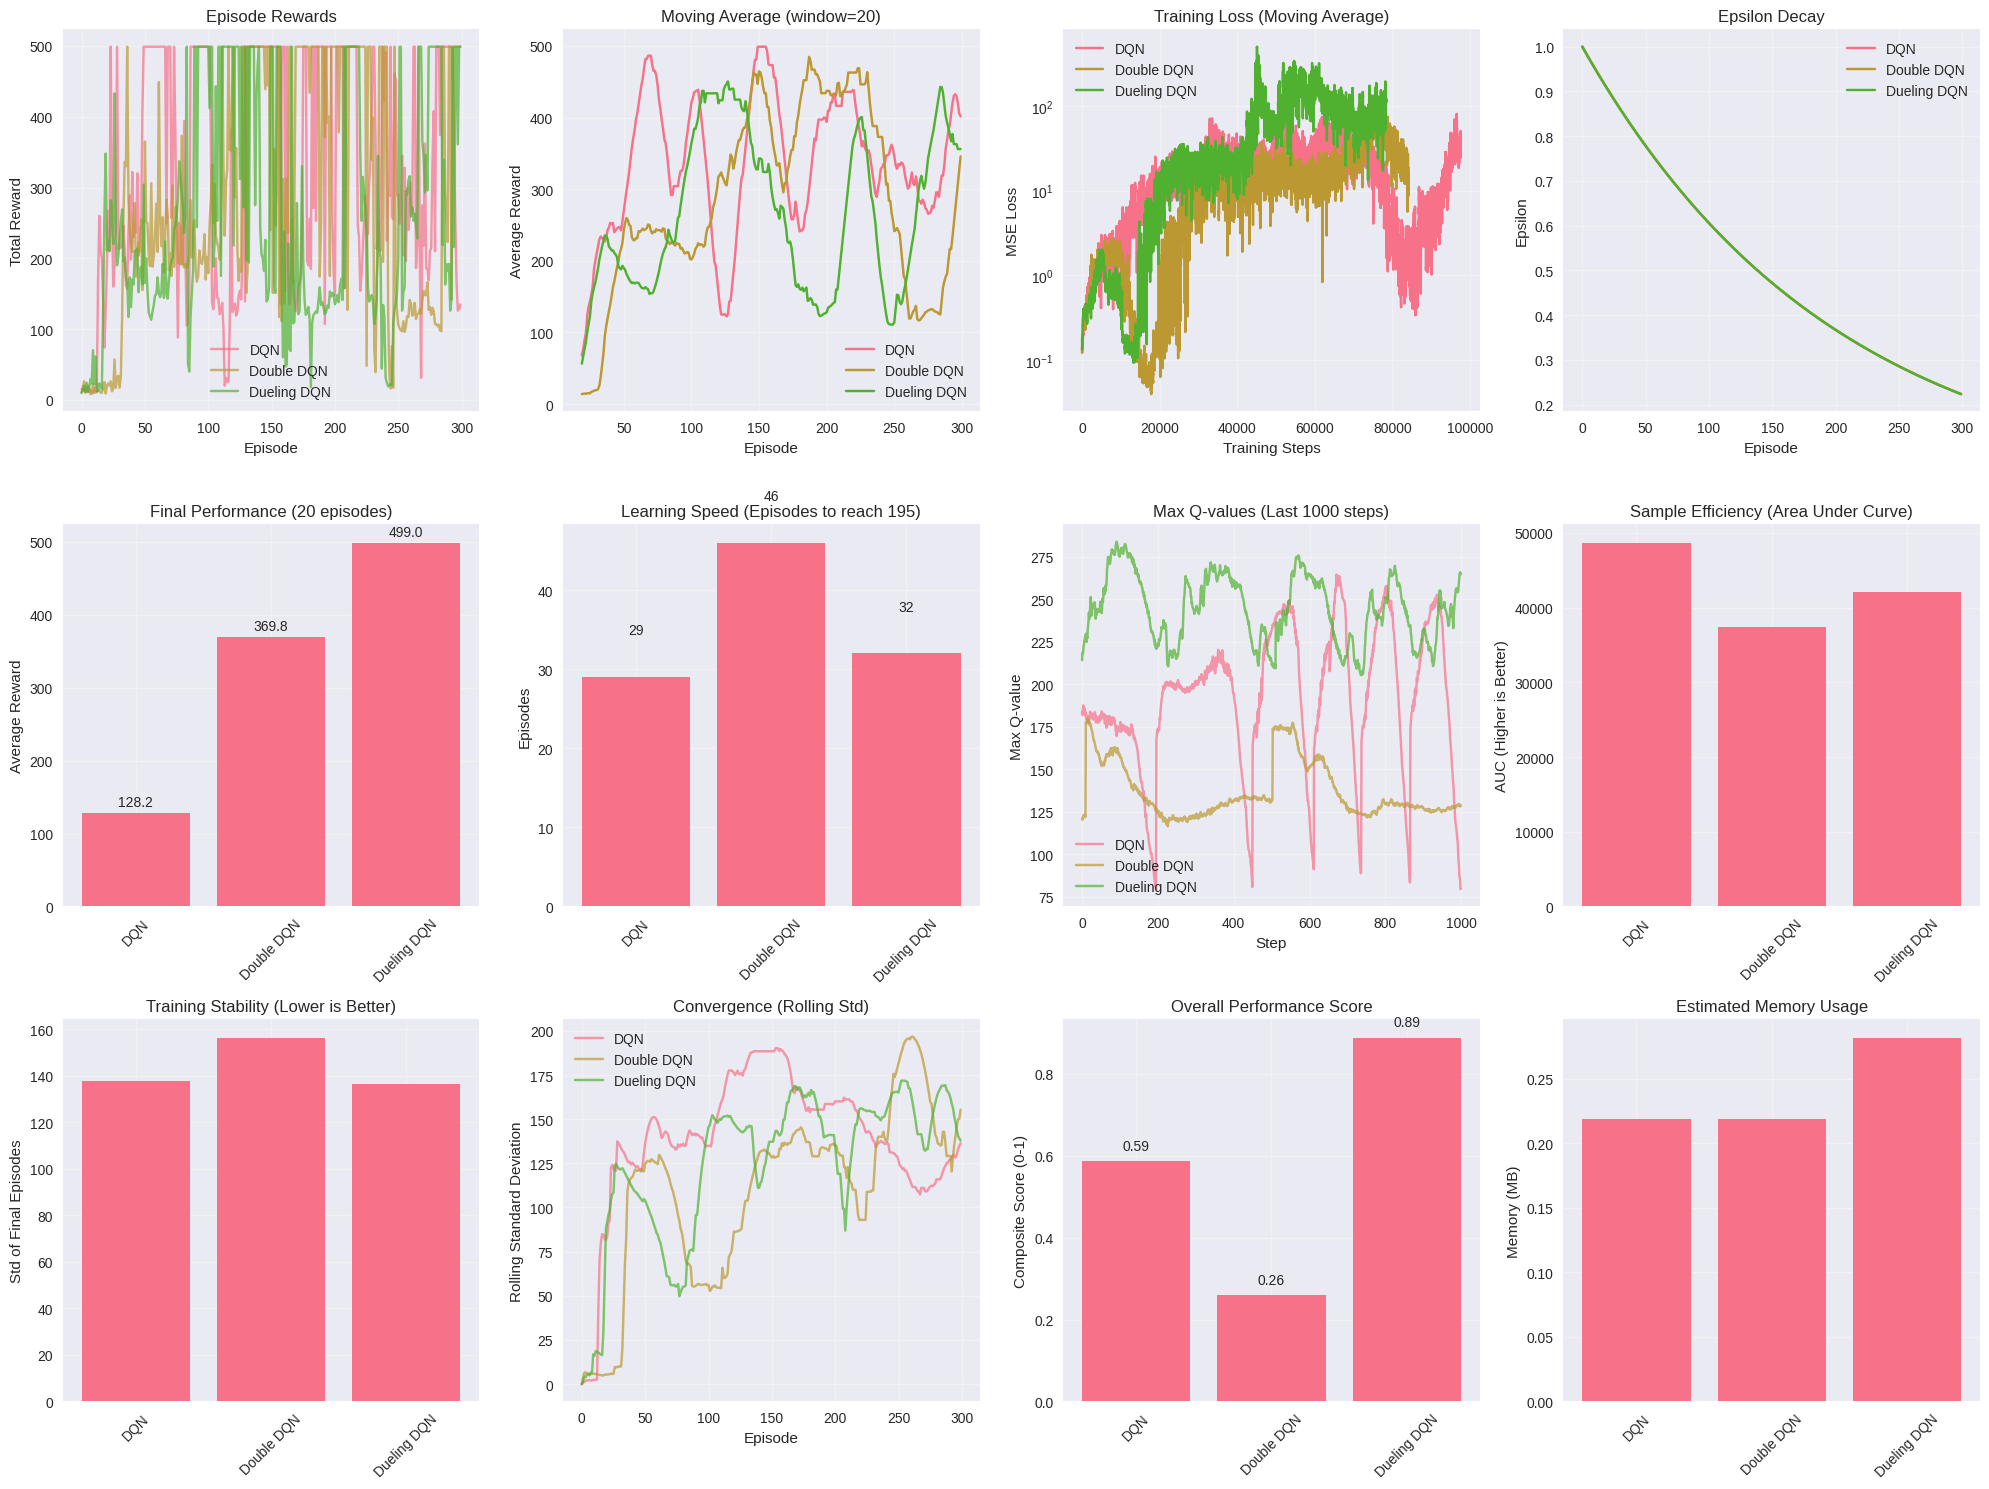


DEEP REINFORCEMENT LEARNING ALGORITHMS COMPARISON
Algorithm       Final Perf   Learning Speed  Stability    Composite 
--------------------------------------------------------------------------------
DQN             128.2        29              137.6        0.587     
Double DQN      369.8        46              156.4        0.261     
Dueling DQN     499.0        32              136.3        0.889     

Best overall algorithm: Dueling DQN (score: 0.889)


In [9]:
# Performance comparison
plt.figure(figsize=(20, 15))

# Episode rewards
plt.subplot(3, 4, 1)
for name, agent in agents.items():
    plt.plot(agent.episode_rewards, label=name, alpha=0.7)
plt.title('Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.grid(True, alpha=0.3)

# Moving averages
plt.subplot(3, 4, 2)
window = 20
for name, agent in agents.items():
    if len(agent.episode_rewards) >= window:
        moving_avg = np.convolve(agent.episode_rewards, np.ones(window)/window, mode='valid')
        plt.plot(range(window-1, len(agent.episode_rewards)), moving_avg, label=name)
plt.title(f'Moving Average (window={window})')
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.legend()
plt.grid(True, alpha=0.3)

# Training losses
plt.subplot(3, 4, 3)
for name, agent in agents.items():
    if len(agent.losses) > 0:
        # Moving average of losses
        loss_window = 100
        if len(agent.losses) >= loss_window:
            loss_avg = np.convolve(agent.losses, np.ones(loss_window)/loss_window, mode='valid')
            plt.plot(loss_avg, label=name)
plt.title('Training Loss (Moving Average)')
plt.xlabel('Training Steps')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')

# Epsilon decay
plt.subplot(3, 4, 4)
episodes = range(training_episodes)
for name, agent in agents.items():
    # Reconstruct epsilon decay
    epsilons = []
    epsilon = 1.0
    for ep in episodes:
        epsilons.append(epsilon)
        epsilon = max(0.01, epsilon * 0.995)
    plt.plot(episodes, epsilons, label=name)
plt.title('Epsilon Decay')
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.legend()
plt.grid(True, alpha=0.3)

# Final performance comparison
plt.subplot(3, 4, 5)
final_performances = []
names = []
for name, agent in agents.items():
    eval_env = CartPoleEnv()
    avg_reward, std_reward = agent.evaluate(eval_env, num_episodes=20)
    final_performances.append(avg_reward)
    names.append(name)

bars = plt.bar(names, final_performances)
plt.title('Final Performance (20 episodes)')
plt.ylabel('Average Reward')
plt.xticks(rotation=45)

for bar, value in zip(bars, final_performances):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
             f'{value:.1f}', ha='center', va='bottom')

plt.grid(True, alpha=0.3)

# Learning speed comparison
plt.subplot(3, 4, 6)
solve_threshold = 195  # CartPole is "solved" at 195 average reward
learning_speeds = []

for name, agent in agents.items():
    window = 20
    if len(agent.episode_rewards) >= window:
        moving_avg = np.convolve(agent.episode_rewards, np.ones(window)/window, mode='valid')
        solved_episodes = np.where(moving_avg >= solve_threshold)[0]
        if len(solved_episodes) > 0:
            learning_speed = solved_episodes[0] + window - 1
        else:
            learning_speed = len(agent.episode_rewards)
    else:
        learning_speed = len(agent.episode_rewards)

    learning_speeds.append(learning_speed)

bars = plt.bar(names, learning_speeds)
plt.title(f'Learning Speed (Episodes to reach {solve_threshold})')
plt.ylabel('Episodes')
plt.xticks(rotation=45)

for bar, value in zip(bars, learning_speeds):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
             f'{value}', ha='center', va='bottom')

plt.grid(True, alpha=0.3)

# Q-value analysis (if available)
plt.subplot(3, 4, 7)
for name, agent in agents.items():
    if len(agent.q_values) > 0:
        # Plot evolution of max Q-values
        max_q_values = [np.max(q) for q in agent.q_values[-1000:]]  # Last 1000 steps
        plt.plot(max_q_values, label=name, alpha=0.7)

plt.title('Max Q-values (Last 1000 steps)')
plt.xlabel('Step')
plt.ylabel('Max Q-value')
plt.legend()
plt.grid(True, alpha=0.3)

# Sample efficiency
plt.subplot(3, 4, 8)
sample_efficiency = []
for name, agent in agents.items():
    # Area under the learning curve (lower is better for faster learning)
    window = 20
    if len(agent.episode_rewards) >= window:
        moving_avg = np.convolve(agent.episode_rewards, np.ones(window)/window, mode='valid')
        # Normalize and invert so higher is better
        auc = np.trapz(moving_avg[:150] if len(moving_avg) >= 150 else moving_avg)
        sample_efficiency.append(auc)
    else:
        sample_efficiency.append(0)

bars = plt.bar(names, sample_efficiency)
plt.title('Sample Efficiency (Area Under Curve)')
plt.ylabel('AUC (Higher is Better)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Stability analysis
plt.subplot(3, 4, 9)
stabilities = []
for name, agent in agents.items():
    # Standard deviation of final 50 episodes
    final_episodes = agent.episode_rewards[-50:] if len(agent.episode_rewards) >= 50 else agent.episode_rewards
    stability = np.std(final_episodes)
    stabilities.append(stability)

bars = plt.bar(names, stabilities)
plt.title('Training Stability (Lower is Better)')
plt.ylabel('Std of Final Episodes')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Convergence analysis
plt.subplot(3, 4, 10)
for name, agent in agents.items():
    rewards = np.array(agent.episode_rewards)
    window = 50
    if len(rewards) >= window:
        # Rolling standard deviation
        rolling_std = [np.std(rewards[max(0, i-window):i+1]) for i in range(len(rewards))]
        plt.plot(rolling_std, label=name, alpha=0.7)

plt.title('Convergence (Rolling Std)')
plt.xlabel('Episode')
plt.ylabel('Rolling Standard Deviation')
plt.legend()
plt.grid(True, alpha=0.3)

# Algorithm comparison summary
plt.subplot(3, 4, 11)
# Normalize metrics for radar chart
metrics = {
    'Performance': final_performances,
    'Speed': [max(learning_speeds) - x for x in learning_speeds],  # Inverted
    'Stability': [max(stabilities) - x for x in stabilities],  # Inverted
    'Sample Eff': sample_efficiency
}

# Normalize to 0-1
for metric, values in metrics.items():
    if max(values) > min(values):
        metrics[metric] = [(x - min(values)) / (max(values) - min(values)) for x in values]
    else:
        metrics[metric] = [0.5] * len(values)

# Composite score
composite_scores = []
for i in range(len(names)):
    score = (metrics['Performance'][i] * 0.4 +
             metrics['Speed'][i] * 0.3 +
             metrics['Stability'][i] * 0.2 +
             metrics['Sample Eff'][i] * 0.1)
    composite_scores.append(score)

bars = plt.bar(names, composite_scores)
plt.title('Overall Performance Score')
plt.ylabel('Composite Score (0-1)')
plt.xticks(rotation=45)

for bar, score in zip(bars, composite_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f'{score:.2f}', ha='center', va='bottom')

plt.grid(True, alpha=0.3)

# Memory usage comparison
plt.subplot(3, 4, 12)
memory_usage = []
for name, agent in agents.items():
    # Estimate memory usage (buffer + network parameters)
    buffer_size = len(agent.replay_buffer) * 4 * 4  # Approximate bytes per experience

    if TORCH_AVAILABLE and hasattr(agent.q_network, 'parameters'):
        network_params = sum(p.numel() for p in agent.q_network.parameters())
        network_size = network_params * 4  # 4 bytes per float
    else:
        network_size = 64 * 64 * 4 + 64 * 2 * 4  # Rough estimate

    total_memory = (buffer_size + network_size) / (1024 * 1024)  # MB
    memory_usage.append(total_memory)

bars = plt.bar(names, memory_usage)
plt.title('Estimated Memory Usage')
plt.ylabel('Memory (MB)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary table
print("\n" + "="*80)
print("DEEP REINFORCEMENT LEARNING ALGORITHMS COMPARISON")
print("="*80)
print(f"{'Algorithm':<15} {'Final Perf':<12} {'Learning Speed':<15} {'Stability':<12} {'Composite':<10}")
print("-"*80)

for i, name in enumerate(names):
    print(f"{name:<15} {final_performances[i]:<12.1f} {learning_speeds[i]:<15} {stabilities[i]:<12.1f} {composite_scores[i]:<10.3f}")

# Find best algorithm
best_idx = np.argmax(composite_scores)
print(f"\nBest overall algorithm: {names[best_idx]} (score: {composite_scores[best_idx]:.3f})")
print("="*80)

## 8.9 Advanced Techniques

Implement additional deep RL techniques like prioritized experience replay.

In [10]:
class PrioritizedDQNAgent(DQNAgent):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        # Replace replay buffer with prioritized version
        self.replay_buffer = PrioritizedReplayBuffer(kwargs.get('buffer_size', 10000))
        self.beta = 0.4
        self.beta_increment = 0.001

    def train_step(self):
        if len(self.replay_buffer) < self.batch_size:
            return

        # Sample batch with priorities
        batch_data = self.replay_buffer.sample(self.batch_size, self.beta)
        if batch_data is None:
            return

        states, actions, rewards, next_states, dones, indices, weights = batch_data

        if TORCH_AVAILABLE:
            states = torch.FloatTensor(states).to(self.device)
            actions = torch.LongTensor(actions).to(self.device)
            rewards = torch.FloatTensor(rewards).to(self.device)
            next_states = torch.FloatTensor(next_states).to(self.device)
            dones = torch.BoolTensor(dones).to(self.device)
            weights = torch.FloatTensor(weights).to(self.device)

            # Current Q-values
            current_q_values = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze()

            # Target Q-values
            with torch.no_grad():
                next_q_values = self.target_network(next_states).max(1)[0]
                target_q_values = rewards + (self.gamma * next_q_values * ~dones)

            # TD errors for priority updates
            td_errors = torch.abs(current_q_values - target_q_values).detach().cpu().numpy()

            # Weighted loss
            loss = (weights * F.mse_loss(current_q_values, target_q_values, reduction='none')).mean()

            # Optimize
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            self.losses.append(loss.item())

            # Update priorities
            priorities = td_errors + 1e-6  # Small epsilon to avoid zero priorities
            self.replay_buffer.update_priorities(indices, priorities)
        else:
            # Simplified version for non-PyTorch
            current_q_values = self.q_network.forward(states)
            next_q_values = self.target_network.forward(next_states)

            targets = current_q_values.copy()
            td_errors = []

            for i in range(self.batch_size):
                if dones[i]:
                    target = rewards[i]
                else:
                    target = rewards[i] + self.gamma * np.max(next_q_values[i])

                td_error = abs(target - current_q_values[i, actions[i]])
                td_errors.append(td_error)
                targets[i, actions[i]] = target

            # Apply importance sampling weights
            weighted_targets = targets.copy()
            for i in range(self.batch_size):
                weighted_targets[i, actions[i]] = (
                    current_q_values[i, actions[i]] +
                    weights[i] * (targets[i, actions[i]] - current_q_values[i, actions[i]])
                )

            # Backpropagation
            self.q_network.backward(weighted_targets, current_q_values)

            # Update priorities
            priorities = [td + 1e-6 for td in td_errors]
            self.replay_buffer.update_priorities(indices, priorities)

            # Calculate loss for tracking
            loss = np.mean((current_q_values - targets) ** 2)
            self.losses.append(loss)

        # Update target network
        self.update_count += 1
        if self.update_count % self.target_update_freq == 0:
            self.update_target_network()

        # Decay epsilon and increase beta
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        self.beta = min(1.0, self.beta + self.beta_increment)

# Test prioritized DQN (if we have enough computational resources)
if len(agents) <= 3:  # Only if we haven't trained too many agents already
    print("Training Prioritized DQN...")

    prioritized_agent = PrioritizedDQNAgent(
        state_dim=env.get_state_dim(),
        action_dim=env.get_action_dim(),
        lr=0.001,
        hidden_dims=[64, 64] if not TORCH_AVAILABLE else [128, 128],
        epsilon_decay=0.995
    )

    # Train for fewer episodes due to computational cost
    train_episodes = 200
    for episode in tqdm(range(train_episodes), desc="Prioritized DQN"):
        env = CartPoleEnv()
        prioritized_agent.train_episode(env)

    # Evaluate
    eval_env = CartPoleEnv()
    final_reward, final_std = prioritized_agent.evaluate(eval_env, num_episodes=20)
    print(f"Prioritized DQN final performance: {final_reward:.1f}±{final_std:.1f}")

    agents['Prioritized DQN'] = prioritized_agent
else:
    print("Skipping Prioritized DQN training to save computational resources")

print(f"\nTotal agents trained: {len(agents)}")

Training Prioritized DQN...


Prioritized DQN: 100%|██████████| 200/200 [03:20<00:00,  1.00s/it]


Prioritized DQN final performance: 189.6±6.1

Total agents trained: 4


## 🎯 Chapter 8 Summary

This notebook demonstrated deep reinforcement learning algorithms and their key innovations:

### Key Algorithms Implemented:

1. **Deep Q-Network (DQN)** [5]:
   - Neural network function approximation
   - Experience replay for stable learning
   - Target networks for improved stability

2. **Double DQN** [6]:
   - Addresses overestimation bias in Q-learning
   - Uses main network for action selection, target for evaluation
   - More accurate Q-value estimates

3. **Dueling DQN** [7]:
   - Separate value and advantage streams
   - Better learning of state values
   - Improved performance in environments with many actions

4. **Prioritized Experience Replay**:
   - Samples important experiences more frequently
   - Faster learning from significant transitions
   - Importance sampling for unbiased updates

### Key Insights:

- **Experience replay** is crucial for stable deep RL [5]
- **Target networks** prevent moving target problems [5]
- **Double DQN** reduces overestimation bias [6]
- **Dueling architecture** improves value function learning [7]
- **Prioritized replay** can accelerate learning

### Best Practices:

1. **Use experience replay** with sufficient buffer size
2. **Update target networks** periodically, not every step
3. **Monitor Q-values** to detect overestimation
4. **Tune hyperparameters** carefully (lr, epsilon decay, etc.)
5. **Consider problem structure** when choosing architecture

### Implementation Notes:

- **PyTorch implementation** provides full functionality
- **NumPy fallback** demonstrates core concepts
- **Memory efficiency** important for large replay buffers
- **Computational cost** scales with network size and buffer

### References:
- [1] Sutton, R. S., & Barto, A. G. (2018). *Reinforcement learning: An introduction*
- [5] Mnih, V., et al. (2015). Human-level control through deep reinforcement learning. *Nature*
- [6] Van Hasselt, H., et al. (2016). Deep reinforcement learning with double Q-learning
- [7] Wang, Z., et al. (2016). Dueling network architectures for deep reinforcement learning

### Cross-References:
- **Previous**: [Chapter 7: Function Approximation](chapter07_function_approximation.ipynb)
- **Next**: [Chapter 9: Policy Gradients](chapter09_policy_gradients.ipynb)
- **Related**: [Chapter 6: Q-Learning Extensions](chapter06_q_learning_extensions.ipynb)

### Next Steps:
- Chapter 9: Policy Gradient Methods
- Experiment with different network architectures
- Try on more complex environments (Atari, continuous control)
- Implement additional techniques (Rainbow DQN, distributional RL)

---
*This notebook is part of the Reinforcement Learning for Engineer-Mathematicians textbook. For complete bibliography, see [bibliography.md](bibliography.md)*